In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [4]:
affr_df = pd.read_csv('dataset/Reviews.csv')
affr_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
affr_df = affr_df[['Text', 'Score']]
affr_df.dropna(inplace=True)
affr_df[affr_df['Score']!=3]
affr_df['sentiment'] = np.where(affr_df['Score'] > 3,1,0)
affr_df.head()

,Text,Score,sentiment
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


In [6]:
X_train, X_test, y_train, y_test = train_test_split(affr_df['Text'], affr_df['sentiment'], random_state = 42)

print('Train:')
print(X_train.shape)
print(y_train.shape)


print('Test:')
print(X_test.shape)
print(y_test.shape)

Train:
(426340,)
(426340,)
Test:
(142114,)
(142114,)


### Bag of Words

We'll compare Count Vectorizer and TF-IDF Vectorizer of the scikit-learn methods. These methods are bag of words techniques which basically counts how often a word occurs. 

CountVectorizer - Converts a collection of text documents to a matrix of token counts
Tf-IdfVectorizer - Similar to CountVectorizer, but uses frequency of the word in the corpus as an offset. This determines the importance of the word

Stop words are the most common words which have little importance such as below words mentioned in nlp.stanford.edu. We will drop them from our analysis.

<img src="https://nlp.stanford.edu/IR-book/html/htmledition/img95.png" title="Common Stop Words"  />

In [7]:
cv_vector = CountVectorizer(stop_words='english', max_df=0.95).fit(X_train)
# max_df :  ignore terms that have a document frequency strictly higher 
#           than the given threshold (corpus-specific stop words).
print(cv_vector)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


In [8]:
print('Number of features: {}'.format(len(cv_vector.get_feature_names())))

Number of features: 105823


In [10]:
X_train_vector = cv_vector.transform(X_train)

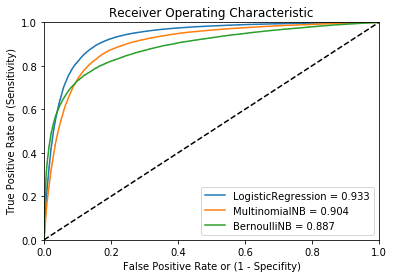

In [24]:
classifiers = [
    LogisticRegression(),
    MultinomialNB(),
    BernoulliNB()
]

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train_vector, y_train)
    train_predictions = clf.predict_proba(cv_vector.transform(X_test))

    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(y_test, train_predictions[:,1])
    roc_auc = auc(fpr, tpr)
    name = clf.__class__.__name__
    # Plot ROC curve
    plt.plot(fpr, tpr, label= name+ ' = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
tfidf_vector = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5).fit(X_train)
print(tfidf_vector)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)


In [29]:
X_train_vector_tfidf = tfidf_vector.transform(X_train)

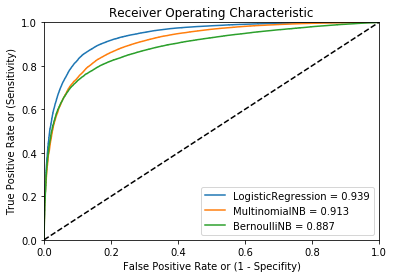

In [30]:
classifiers = [
    LogisticRegression(),
    MultinomialNB(),
    BernoulliNB()
]

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train_vector_tfidf, y_train)
    train_predictions = clf.predict_proba(tfidf_vector.transform(X_test))

    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(y_test, train_predictions[:,1])
    roc_auc = auc(fpr, tpr)
    name = clf.__class__.__name__
    # Plot ROC curve
    plt.plot(fpr, tpr, label= name+ ' = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()